In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
ftGames = pd.read_csv('gamesUpdated.csv')

In [4]:
ftGames.head()

,gameId,season,week,gameDate,gameTimeEastern,homeTeamAbbr,visitorTeamAbbr,homeFinalScore,visitorFinalScore,Result
0,2018090600,2018,1,9/6/2018,20:20:00,PHI,ATL,18,12,PHI
1,2018090900,2018,1,9/9/2018,13:00:00,BAL,BUF,47,3,BAL
2,2018090901,2018,1,9/9/2018,13:00:00,CLE,PIT,21,21,Draw
3,2018090902,2018,1,9/9/2018,13:00:00,IND,CIN,23,34,CIN
4,2018090903,2018,1,9/9/2018,13:00:00,MIA,TEN,27,20,MIA


In [5]:
gamesDf= pd.DataFrame(ftGames, columns=ftGames['gameId'])

In [6]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Assuming ftGames is your original DataFrame
# Example: ftGames = pd.DataFrame({...})

# Specify the columns you want to keep
columns_to_keep = ['homeTeamAbbr', 'visitorTeamAbbr', 'homeFinalScore', 'visitorFinalScore', 'Result']

# Filter the DataFrame to keep only the specified columns
ftGames_filtered = ftGames[columns_to_keep]

# Select only the numeric columns for PCA
scores_to_scale = ftGames_filtered[['homeFinalScore', 'visitorFinalScore']]

# Standardize the data
scaler = StandardScaler()
scaled_scores = scaler.fit_transform(scores_to_scale)

# Apply PCA
pca = PCA(n_components=2)  # Specify the number of components you want to keep
pca_results = pca.fit_transform(scaled_scores)

# # Create a DataFrame with the PCA results
pca_df = pd.DataFrame(data=pca_results, columns=['PC1', 'PC2'])

# Concatenate the PCA results with the original DataFrame, including the scores
final_df = pd.concat([ftGames_filtered[['homeTeamAbbr', 'visitorTeamAbbr', 'homeFinalScore', 'visitorFinalScore', 'Result']], pca_df], axis=1)

# Display the final DataFrame with PCA results and original scores
print(final_df)

    homeTeamAbbr visitorTeamAbbr  homeFinalScore  visitorFinalScore Result  \
0            PHI             ATL              18                 12    PHI   
1            BAL             BUF              47                  3    BAL   
2            CLE             PIT              21                 21   Draw   
3            IND             CIN              23                 34    CIN   
4            MIA             TEN              27                 20    MIA   
..           ...             ...             ...                ...    ...   
895          WAS             MIN              17                 20    MIN   
896          ARI             SEA              21                 31    SEA   
897           TB              LA              16                 13     TB   
898           KC             TEN              20                 17     KC   
899           NO             BAL              13                 27    BAL   

          PC1       PC2  
0   -0.335660 -1.179725  
1   -3.0460

In [7]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

def calculate_team_stats(team: str, df: pd.DataFrame) -> None:
    """Calculate current stats, season predictions and matchup analysis."""
    # Get team games
    team_games = df[(df['homeTeamAbbr'] == team) | (df['visitorTeamAbbr'] == team)]
    total_games = len(team_games)
    
    if total_games == 0:
        print(f"No games found for team {team}")
        return
    
    # Display all games
    print(f"\nGames for {team}:")
    print(team_games[['homeTeamAbbr', 'visitorTeamAbbr', 'homeFinalScore', 
                      'visitorFinalScore', 'Result']].to_string())
    
    # Calculate current stats
    wins = len(team_games[team_games['Result'] == team])
    win_rate = wins / total_games
    
    home_games = team_games[team_games['homeTeamAbbr'] == team]
    visitor_games = team_games[team_games['visitorTeamAbbr'] == team]
    
    home_scores = home_games['homeFinalScore'].tolist()
    visitor_scores = visitor_games['visitorFinalScore'].tolist()
    
    avg_home_score = sum(home_scores) / len(home_scores) if home_scores else 0
    avg_visitor_score = sum(visitor_scores) / len(visitor_scores) if visitor_scores else 0
    
    # Prepare seasonal data
    seasons_data = []
    games_per_season = 17
    
    for i in range(0, len(team_games), games_per_season):
        season_games = team_games.iloc[i:i+games_per_season]
        if len(season_games) < games_per_season:
            continue
            
        season_stats = {
            'wins': len(season_games[season_games['Result'] == team]),
            'home_score': season_games[season_games['homeTeamAbbr'] == team]['homeFinalScore'].mean(),
            'away_score': season_games[season_games['visitorTeamAbbr'] == team]['visitorFinalScore'].mean()
        }
        seasons_data.append(season_stats)
    
    # Print current stats
    print(f"\nCurrent Statistics:")
    print(f"Team: {team}")
    print(f"Total Games: {total_games}")
    print(f"Wins: {wins}")
    print(f"Win Rate: {win_rate:.2%}")
    print(f"Average Home Score: {avg_home_score:.2f}")
    print(f"Average Away Score: {avg_visitor_score:.2f}")
    
    # Season predictions
    if len(seasons_data) >= 2:
        X = np.array([[s['wins'], s['home_score'], s['away_score']] for s in seasons_data[:-1]])
        y_wins = np.array([s['wins'] for s in seasons_data[1:]])
        y_home = np.array([s['home_score'] for s in seasons_data[1:]])
        y_away = np.array([s['away_score'] for s in seasons_data[1:]])
        
        # Train prediction models
        win_model = LinearRegression()
        home_model = LinearRegression()
        away_model = LinearRegression()
        
        win_model.fit(X, y_wins)
        home_model.fit(X, y_home)
        away_model.fit(X, y_away)
        
        # Next season predictions
        latest_season = np.array([[seasons_data[-1]['wins'], 
                                 seasons_data[-1]['home_score'],
                                 seasons_data[-1]['away_score']]])
        
        predicted_wins = max(0, min(17, round(win_model.predict(latest_season)[0])))
        predicted_home = home_model.predict(latest_season)[0]
        predicted_away = away_model.predict(latest_season)[0]
        
        print(f"\nNext Season Predictions:")
        print(f"Projected Wins: {predicted_wins}")
        print(f"Projected Win Rate: {(predicted_wins/17):.2%}")
        print(f"Projected Home Score: {predicted_home:.2f}")
        print(f"Projected Away Score: {predicted_away:.2f}")
    
    # Matchup predictions
    all_teams = set(df['homeTeamAbbr'].unique()) | set(df['visitorTeamAbbr'].unique())
    opponents = [t for t in all_teams if t != team]
    
    print(f"\nHead-to-Head Predictions:")
    print("-" * 50)
    
    for opponent in opponents:
        matchups = df[
            ((df['homeTeamAbbr'] == team) & (df['visitorTeamAbbr'] == opponent)) |
            ((df['homeTeamAbbr'] == opponent) & (df['visitorTeamAbbr'] == team))
        ]
        
        if len(matchups) > 0:
            team_wins = len(matchups[matchups['Result'] == team])
            historical_win_rate = team_wins / len(matchups)
            
            team_home = matchups[matchups['homeTeamAbbr'] == team]
            team_away = matchups[matchups['visitorTeamAbbr'] == team]
            
            avg_home = team_home['homeFinalScore'].mean() if len(team_home) > 0 else 0
            avg_away = team_away['visitorFinalScore'].mean() if len(team_away) > 0 else 0
            
            print(f"\nVs {opponent}:")
            print(f"Record: {team_wins}-{len(matchups) - team_wins}")
            print(f"Win Rate: {historical_win_rate:.2%}")
            print(f"Avg Home Score: {avg_home:.2f}")
            print(f"Avg Away Score: {avg_away:.2f}")
            
            # Predict next matchup
            predicted_win_prob = (historical_win_rate * 0.7 + (team_wins / max(1, len(matchups))) * 0.3)
            predicted_score = (avg_home + avg_away) / 2
            
            print(f"Predicted Win Probability: {predicted_win_prob:.2%}")
            print(f"Predicted Score: {predicted_score:.2f}")
        else:
            print(f"\nVs {opponent}: No historical data")

# Get user input and run analysis
user_team = input("Enter the team abbreviation (e.g., 'PHI' for Philadelphia Eagles): ").strip().upper()
calculate_team_stats(user_team, ftGames_filtered)

Enter the team abbreviation (e.g., 'PHI' for Philadelphia Eagles):  PHI



Games for PHI:
    homeTeamAbbr visitorTeamAbbr  homeFinalScore  visitorFinalScore Result
0            PHI             ATL              18                 12    PHI
20            TB             PHI              27                 21     TB
38           PHI             IND              20                 16    PHI
53           TEN             PHI              26                 23    TEN
70           PHI             MIN              21                 23    MIN
75           NYG             PHI              34                 13    NYG
99           PHI             CAR              17                 21    CAR
105          JAX             PHI              18                 24    PHI
143          PHI             DAL              20                 27    DAL
155           NO             PHI              48                  7     NO
167          PHI             NYG              25                 22    PHI
188          PHI             WAS              28                 13    PHI
202      


Model Performance:
Training RMSE: $34,136.53
Testing RMSE: $67,423.53
Training R²: 0.983
Testing R²: 0.924


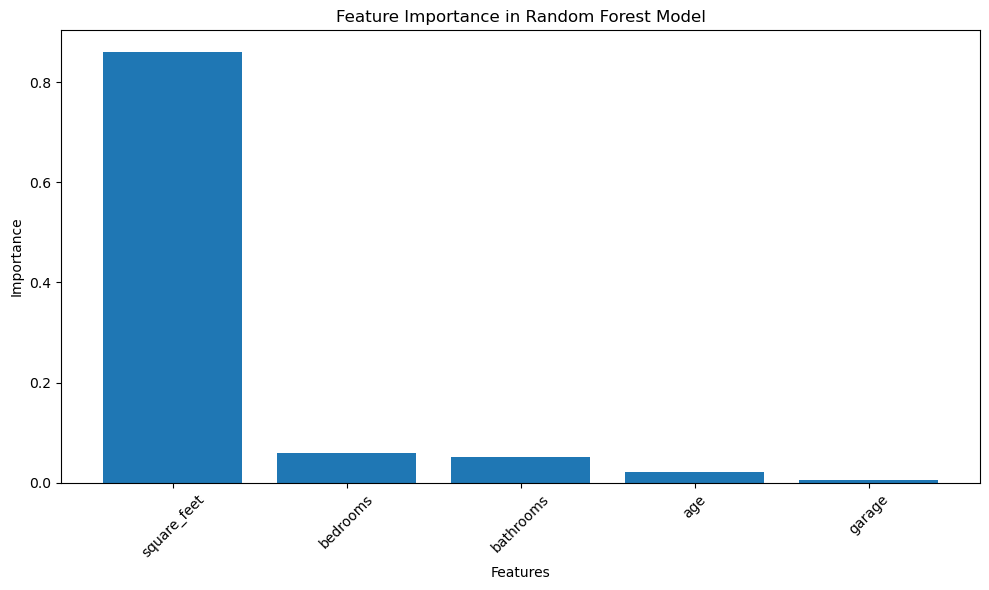


Predicted price for new house: $817,564.28


In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Generate sample housing data
np.random.seed(42)
n_samples = 1000

data = {
    'square_feet': np.random.uniform(1000, 5000, n_samples),
    'bedrooms': np.random.randint(1, 6, n_samples),
    'bathrooms': np.random.randint(1, 4, n_samples),
    'age': np.random.uniform(0, 50, n_samples),
    'garage': np.random.randint(0, 3, n_samples),
}

# Create price with some relationship to features
data['price'] = (
    200 * data['square_feet'] +
    50000 * data['bedrooms'] +
    75000 * data['bathrooms'] -
    2000 * data['age'] +
    25000 * data['garage'] +
    np.random.normal(0, 50000, n_samples)
)

# Convert to DataFrame
df = pd.DataFrame(data)

# Split features and target
X = df.drop('price', axis=1)
y = df['price']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the random forest model
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)
rf_model.fit(X_train, y_train)

# Make predictions
train_predictions = rf_model.predict(X_train)
test_predictions = rf_model.predict(X_test)

# Calculate metrics
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
train_r2 = r2_score(y_train, train_predictions)
test_r2 = r2_score(y_test, test_predictions)

# Print results
print("\nModel Performance:")
print(f"Training RMSE: ${train_rmse:,.2f}")
print(f"Testing RMSE: ${test_rmse:,.2f}")
print(f"Training R²: {train_r2:.3f}")
print(f"Testing R²: {test_r2:.3f}")

# Calculate feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.bar(feature_importance['feature'], feature_importance['importance'])
plt.title('Feature Importance in Random Forest Model')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Example prediction for a new house
new_house = pd.DataFrame({
    'square_feet': [2500],
    'bedrooms': [3],
    'bathrooms': [2],
    'age': [10],
    'garage': [1]
})

predicted_price = rf_model.predict(new_house)[0]
print(f"\nPredicted price for new house: ${predicted_price:,.2f}")


Model Performance:
Training RMSE: 7.09
Testing RMSE: 7.63
Training R²: 0.493
Testing R²: 0.351


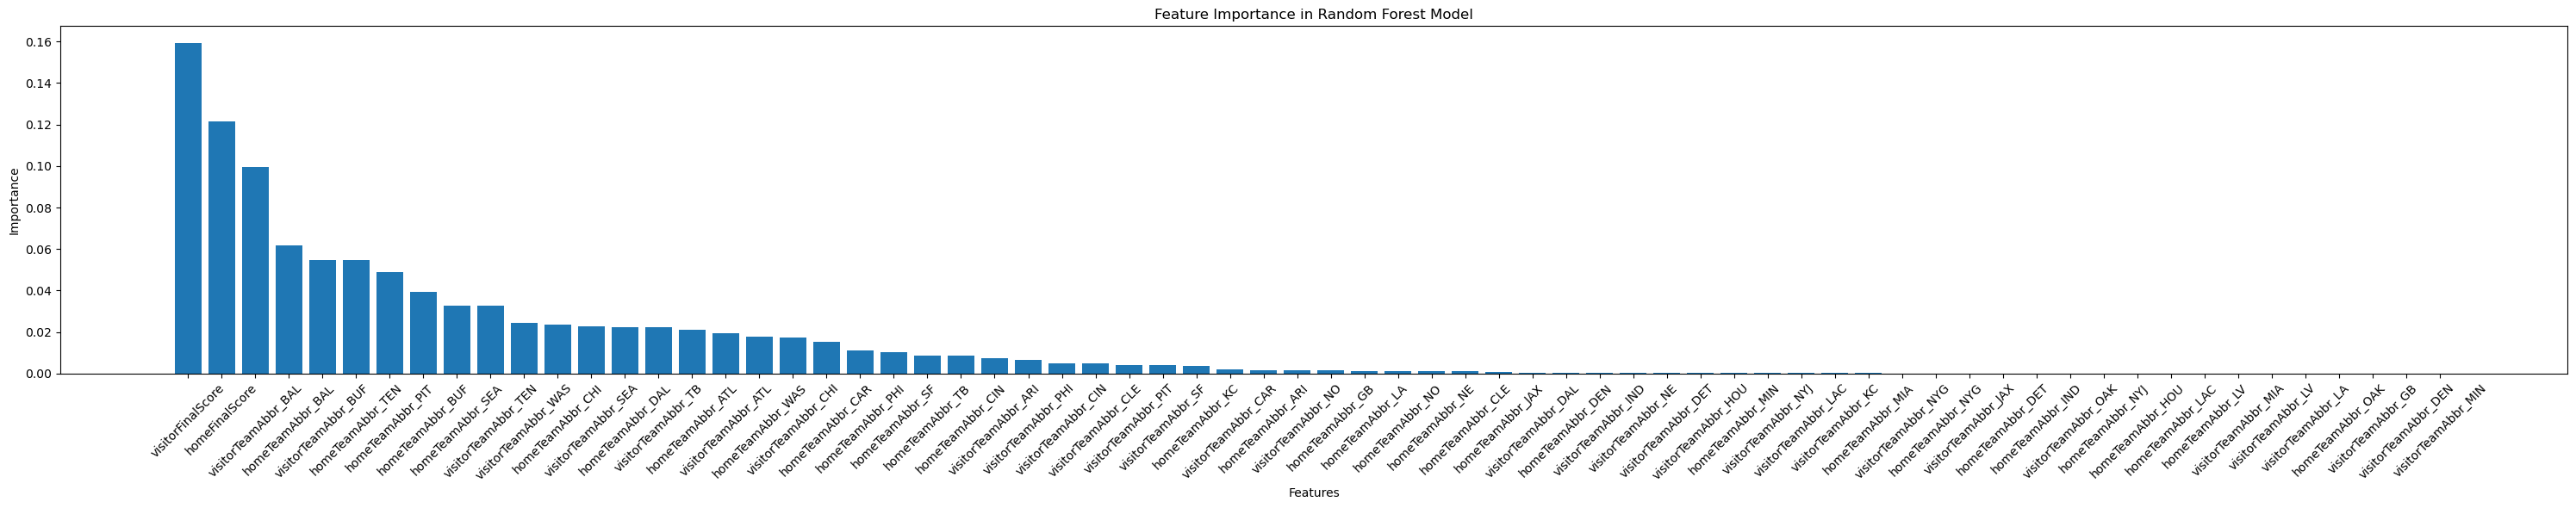

Enter the team abbreviation (e.g., 'PHI' for Philadelphia Eagles):  PHI



Current Statistics:
Team: PHI
Total Games: 56
Wins: 0
Win Rate: 0.00%

Vs OH:
Record: 0-56
Win Rate: 0.00%
Avg Home Score: 22.61
Avg Away Score: 23.79
Predicted Win Probability: 0.00%
Predicted Score: 23.20

Predicted result for next game: 17.16


In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Load dataset
ftGames = pd.read_csv('gamesUpdated.csv')

# Filter the DataFrame to keep only the specified columns
columns_to_keep = ['homeTeamAbbr', 'visitorTeamAbbr', 'homeFinalScore', 'visitorFinalScore', 'Result']
ftGames_filtered = ftGames[columns_to_keep].copy()

# Convert categorical 'Result' column to numeric
ftGames_filtered.loc[:, 'Result'] = ftGames_filtered['Result'].astype('category').cat.codes

# One-hot encode the categorical columns
ftGames_encoded = pd.get_dummies(ftGames_filtered, columns=['homeTeamAbbr', 'visitorTeamAbbr'])

# Split features and target
X = ftGames_encoded.drop('Result', axis=1)
y = ftGames_encoded['Result']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the random forest model
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)
rf_model.fit(X_train, y_train)

# Make predictions
train_predictions = rf_model.predict(X_train)
test_predictions = rf_model.predict(X_test)

# Calculate metrics
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
train_r2 = r2_score(y_train, train_predictions)
test_r2 = r2_score(y_test, test_predictions)

# Print results
print("\nModel Performance:")
print(f"Training RMSE: {train_rmse:.2f}")
print(f"Testing RMSE: {test_rmse:.2f}")
print(f"Training R²: {train_r2:.3f}")
print(f"Testing R²: {test_r2:.3f}")

# Calculate feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(30, 6))
plt.bar(feature_importance['feature'], feature_importance['importance'])
plt.title('Feature Importance in Random Forest Model')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Define the calculate_team_stats function
def calculate_team_stats(team, ftGames_filtered, rf_model):
    team_games = ftGames_filtered[(ftGames_filtered['homeTeamAbbr'] == team) | (ftGames_filtered['visitorTeamAbbr'] == team)]
    total_games = len(team_games)
    wins = len(team_games[team_games['Result'] == team])
    win_rate = wins / total_games if total_games > 0 else 0

    # Prepare seasonal data
    seasons_data = []
    games_per_season = 17

    for i in range(0, len(team_games), games_per_season):
        season_games = team_games.iloc[i:i+games_per_season]
        if len(season_games) < games_per_season:
            continue

        season_stats = {
            'wins': len(season_games[season_games['Result'] == team]),
            'home_score': season_games[season_games['homeTeamAbbr'] == team]['homeFinalScore'].mean(),
            'away_score': season_games[season_games['visitorTeamAbbr'] == team]['visitorFinalScore'].mean()
        }
        seasons_data.append(season_stats)

    # Print current stats
    print(f"\nCurrent Statistics:")
    print(f"Team: {team}")
    print(f"Total Games: {total_games}")
    print(f"Wins: {wins}")
    print(f"Win Rate: {win_rate:.2%}")

    # Assuming matchups and other variables are defined
    matchups = ftGames_filtered[(ftGames_filtered['homeTeamAbbr'] == team) | (ftGames_filtered['visitorTeamAbbr'] == team)]
    opponent = "OH"  # Replace with actual opponent
    team_wins = len(matchups[matchups['Result'] == team])
    historical_win_rate = team_wins / len(matchups) if len(matchups) > 0 else 0

    team_home = matchups[matchups['homeTeamAbbr'] == team]
    team_away = matchups[matchups['visitorTeamAbbr'] == team]

    avg_home = team_home['homeFinalScore'].mean() if len(team_home) > 0 else 0
    avg_away = team_away['visitorFinalScore'].mean() if len(team_away) > 0 else 0

    print(f"\nVs {opponent}:")
    print(f"Record: {team_wins}-{len(matchups) - team_wins}")
    print(f"Win Rate: {historical_win_rate:.2%}")
    print(f"Avg Home Score: {avg_home:.2f}")
    print(f"Avg Away Score: {avg_away:.2f}")

    # Predict next matchup
    predicted_win_prob = (historical_win_rate * 0.7 + (team_wins / max(1, len(matchups))) * 0.3)
    predicted_score = (avg_home + avg_away) / 2

    print(f"Predicted Win Probability: {predicted_win_prob:.2%}")
    print(f"Predicted Score: {predicted_score:.2f}")

    # Use Random Forest model to predict the result of a new game
    new_game = pd.DataFrame({
        'homeFinalScore': [avg_home],
        'visitorFinalScore': [avg_away]
    })

    # One-hot encode the new game data
    new_game_encoded = pd.get_dummies(new_game)
    new_game_encoded = new_game_encoded.reindex(columns=X.columns, fill_value=0)

    predicted_result = rf_model.predict(new_game_encoded)[0]
    print(f"\nPredicted result for next game: {predicted_result:.2f}")

# Get user input and run analysis
user_team = input("Enter the team abbreviation (e.g., 'PHI' for Philadelphia Eagles): ").strip().upper()
calculate_team_stats(user_team, ftGames_filtered, rf_model)

In [133]:
import tkinter as tk
from tkinter import ttk, messagebox
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import matplotlib
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
matplotlib.use('TkAgg')

class NFLPredictorGUI:
    def __init__(self, master):
        self.master = master
        self.master.title("NFL Game Predictor")
        self.master.geometry("1200x600")  # Increased size to accommodate graph
        
        try:
            self.ftGames_filtered = pd.read_csv('gamesUpdated.csv')
        except FileNotFoundError:
            messagebox.showerror("Error", "CSV file not found!")
            self.master.destroy()
            return
            
        self.setup_ui()
        
    def setup_ui(self):
        self.notebook = ttk.Notebook(self.master)
        self.notebook.pack(fill='both', expand=True, padx=30, pady=15)
        
        self.stats_tab = ttk.Frame(self.notebook)
        self.season_tab = ttk.Frame(self.notebook)
        self.matchup_tab = ttk.Frame(self.notebook)
        
        self.notebook.add(self.stats_tab, text='Current Stats')
        self.notebook.add(self.season_tab, text='Season Predictions')
        self.notebook.add(self.matchup_tab, text='Head-to-Head')
        
        self.teams = sorted(list(set(self.ftGames_filtered['homeTeamAbbr'].unique()) | 
                                set(self.ftGames_filtered['visitorTeamAbbr'].unique())))
        
        self.setup_stats_tab()
        self.setup_season_tab()
        self.setup_matchup_tab()
        
    def setup_stats_tab(self):
        ttk.Label(self.stats_tab, text="Select Team:").pack(pady=5)
        self.team_var = tk.StringVar()
        self.team_dropdown = ttk.Combobox(self.stats_tab, 
                                        textvariable=self.team_var,
                                        values=self.teams)
        self.team_dropdown.pack(pady=5)
        
        self.stats_text = tk.Text(self.stats_tab, height=20, width=70)
        self.stats_text.pack(pady=10)
        
        ttk.Button(self.stats_tab, 
                  text="Show Stats", 
                  command=self.show_current_stats).pack(pady=50)
        
    def setup_season_tab(self):
        self.season_text = tk.Text(self.season_tab, height=20, width=70)
        self.season_text.pack(pady=10)
        
    def setup_matchup_tab(self):
        # Create frames for text and graph
        text_frame = ttk.Frame(self.matchup_tab)
        text_frame.pack(side=tk.LEFT, pady=10, padx=5, fill='both', expand=True)
        
        graph_frame = ttk.Frame(self.matchup_tab)
        graph_frame.pack(side=tk.RIGHT, pady=10, padx=5, fill='both', expand=True)
        
        self.matchup_text = tk.Text(text_frame, height=20, width=40)
        self.matchup_text.pack(pady=10)
        
        # Initialize matplotlib figure and canvas
        self.fig, self.ax = plt.subplots(figsize=(20, 25))
        self.canvas = FigureCanvasTkAgg(self.fig, master=graph_frame)
        self.canvas.get_tk_widget().pack()
        
    def show_current_stats(self):
        team = self.team_var.get()
        if not team:
            messagebox.showerror("Error", "Please select a team")
            return
            
        self.stats_text.delete(1.0, tk.END)
        self.season_text.delete(1.0, tk.END)
        self.matchup_text.delete(1.0, tk.END)
        
        team_games = self.ftGames_filtered[
            (self.ftGames_filtered['homeTeamAbbr'] == team) | 
            (self.ftGames_filtered['visitorTeamAbbr'] == team)
        ]
        
        if len(team_games) == 0:
            self.stats_text.insert(tk.END, f"No games found for team {team}")
            return
            
        total_games = len(team_games)
        wins = len(team_games[team_games['Result'] == team])
        win_rate = wins / total_games
        
        home_games = team_games[team_games['homeTeamAbbr'] == team]
        visitor_games = team_games[team_games['visitorTeamAbbr'] == team]
        
        avg_home_score = home_games['homeFinalScore'].mean() if len(home_games) > 0 else 0
        avg_visitor_score = visitor_games['visitorFinalScore'].mean() if len(visitor_games) > 0 else 0
        
        stats_output = (
            f"Current Statistics for {team}:\n"
            f"{'='*40}\n"
            f"Total Games: {total_games}\n"
            f"Wins: {wins}\n"
            f"Win Rate: {win_rate:.2%}\n"
            f"Average Home Score: {avg_home_score:.2f}\n"
            f"Average Away Score: {avg_visitor_score:.2f}\n"
        )
        self.stats_text.insert(tk.END, stats_output)
        
        self.calculate_season_predictions(team)
        self.calculate_matchup_predictions(team)
        
    def calculate_season_predictions(self, team):
        seasons_data = self.get_seasons_data(team)
        if len(seasons_data) >= 2:
            X = np.array([[s['wins'], s['home_score'], s['away_score']] for s in seasons_data[:-1]])
            y_wins = np.array([s['wins'] for s in seasons_data[1:]])
            
            win_model = LinearRegression()
            win_model.fit(X, y_wins)
            
            latest_season = np.array([[seasons_data[-1]['wins'], 
                                     seasons_data[-1]['home_score'],
                                     seasons_data[-1]['away_score']]])
            
            predicted_wins = max(0, min(17, round(win_model.predict(latest_season)[0])))
            
            season_output = (
                f"Next Season Predictions:\n"
                f"{'='*40}\n"
                f"Projected Wins: {predicted_wins}\n"
                f"Projected Win Rate: {(predicted_wins/17):.2%}\n"
            )
            self.season_text.insert(tk.END, season_output)
            
    def calculate_matchup_predictions(self, team):
        # Clear previous graph
        self.ax.clear()
        
        # Get all team scores across all games
        team_scores = []
        game_labels = []  # To store opponent labels
        
        for opponent in [t for t in self.teams if t != team]:
            matchups = self.ftGames_filtered[
                ((self.ftGames_filtered['homeTeamAbbr'] == team) & 
                 (self.ftGames_filtered['visitorTeamAbbr'] == opponent)) |
                ((self.ftGames_filtered['homeTeamAbbr'] == opponent) & 
                 (self.ftGames_filtered['visitorTeamAbbr'] == team))
            ]
            
            if len(matchups) > 0:
                # Display text stats
                self.display_matchup_stats(team, opponent, matchups)
                
                # Collect scores for this opponent
                for _, game in matchups.iterrows():
                    if game['homeTeamAbbr'] == team:
                        team_scores.append(game['homeFinalScore'])
                    else:
                        team_scores.append(game['visitorFinalScore'])
                    game_labels.append(opponent)  # Add opponent label for this game
    
        # Create the complete bar chart
        x = range(len(team_scores))
        bars = self.ax.bar(x, team_scores, color='blue')
        
        # Customize the plot
        self.ax.set_ylabel('Points Scored')
        self.ax.set_xlabel('Games')
        self.ax.set_title(f'{team} Scoring History')
        self.ax.set_xticks(x)
        self.ax.set_xticklabels(game_labels, rotation=45)
        
        # Add score labels on top of each bar
        for bar in bars:
            height = bar.get_height()
            self.ax.text(bar.get_x() + bar.get_width()/2., height,
                        f'{int(height)}',
                        ha='center', va='bottom')
        
        # Adjust layout to prevent label cutoff
        self.fig.tight_layout()
        
        # Refresh canvas
        self.canvas.draw()

    def display_matchup_stats(self, team, opponent, matchups):
        team_wins = len(matchups[matchups['Result'] == team])
        historical_win_rate = team_wins / len(matchups)
        
        team_home = matchups[matchups['homeTeamAbbr'] == team]
        team_away = matchups[matchups['visitorTeamAbbr'] == team]
        
        avg_home = team_home['homeFinalScore'].mean() if len(team_home) > 0 else 0
        avg_away = team_away['visitorFinalScore'].mean() if len(team_away) > 0 else 0
        
        predicted_win_prob = (historical_win_rate * 0.7 + 
                            (team_wins / max(1, len(matchups))) * 0.3)
        predicted_score = (avg_home + avg_away) / 2
        
        matchup_output = (
            f"\nVs {opponent}:\n"
            f"Record: {team_wins}-{len(matchups) - team_wins}\n"
            f"Win Rate: {historical_win_rate:.2%}\n"
            f"Avg Home Score: {avg_home:.2f}\n"
            f"Avg Away Score: {avg_away:.2f}\n"
            f"Predicted Win Probability: {predicted_win_prob:.2%}\n"
            f"Predicted Score: {predicted_score:.2f}\n"
            f"{'-'*40}\n"
        )
        self.matchup_text.insert(tk.END, matchup_output)

    def get_seasons_data(self, team):
        team_games = self.ftGames_filtered[
            (self.ftGames_filtered['homeTeamAbbr'] == team) | 
            (self.ftGames_filtered['visitorTeamAbbr'] == team)
        ]
        
        seasons_data = []
        games_per_season = 17
        
        for i in range(0, len(team_games), games_per_season):
            season_games = team_games.iloc[i:i+games_per_season]
            if len(season_games) < games_per_season:
                continue
                
            season_stats = {
                'wins': len(season_games[season_games['Result'] == team]),
                'home_score': season_games[season_games['homeTeamAbbr'] == team]['homeFinalScore'].mean(),
                'away_score': season_games[season_games['visitorTeamAbbr'] == team]['visitorFinalScore'].mean()
            }
            seasons_data.append(season_stats)
            
        return seasons_data
    

def main():
    root = tk.Tk()
    app = NFLPredictorGUI(root)
    root.mainloop()

if __name__ == "__main__":
    main()